/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Us

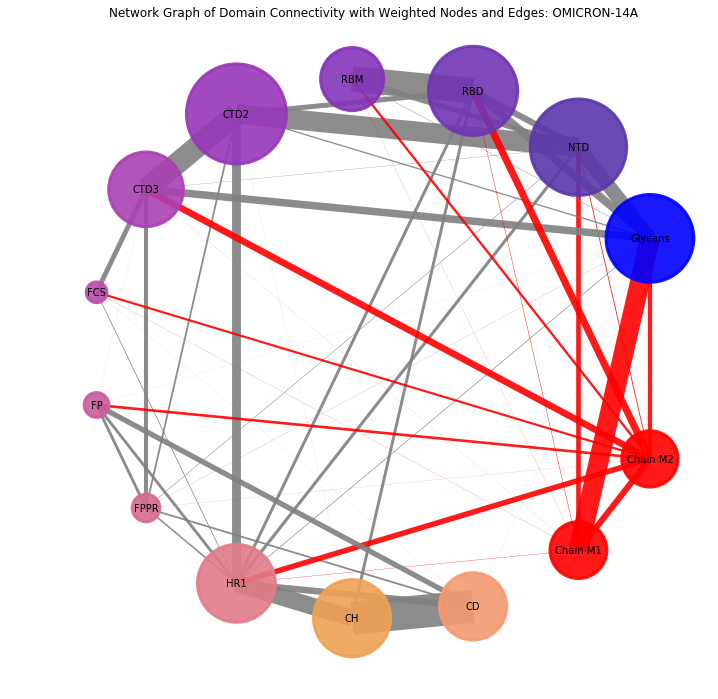

In [7]:
###OMICRON


import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue for OMICRON
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(0, 275)).union(range(1292, 1567)).union(range(2584, 2860)),
        'RBD': set(range(317, 420)).union(range(1607, 1712)).union(range(2899, 3004)).union(range(493, 511)).union(range(1785, 1804)).union(range(3077, 3096)),
        'RBM': set(range(421, 492)).union(range(1713, 1784)).union(range(3005, 3076)),
        'CTD2': set(range(513, 573)).union(range(1805, 1866)).union(range(3097, 3158)),
        'CTD3': set(range(574, 659)).union(range(675, 681)).union(range(1866, 1951)).union(range(1967, 1973)).union(range(3158, 3243)).union(range(3259, 3265)),
        'FCS': set(range(659, 674)).union(range(1951, 1966)).union(range(3243, 3258)),
        'FP': set(range(801, 818)).union(range(2093, 2110)).union(range(3385, 3402)),
        'FPPR': set(range(819, 839)).union(range(2111, 2131)).union(range(3403, 3423)),
        'HR1': set(range(894, 969)).union(range(2186, 2261)).union(range(3478, 3553)),
        'CH': set(range(969, 1018)).union(range(2261, 2310)).union(range(3553, 3602)),
        'CD': set(range(1019, 1052)).union(range(2311, 2344)).union(range(3603, 3636)),
        'Glycans': set(range(1125, 1291)).union(range(2417, 2583)).union(range(3709, 3869)),
        'Chain M1': set(range(3870, 3989)).union(range(4409, 4527)).union(range(4528, 4646)),
        'Chain M2': set(range(3989, 4128)).union(range(4269, 4408)).union(range(4129, 4268))
    }
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to create a circular layout
def circular_layout(G, order):
    pos = {}
    angle = 2 * math.pi / len(order)
    for i, node in enumerate(order):
        theta = i * angle
        pos[node] = (math.cos(theta), math.sin(theta))
    return pos

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights, node_border_width=2.0):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes, including 'Chain M2'
    node_order = [
        'Mucins', 'Glycans', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD', 'Chain M1', 'Chain M2'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [10000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [100 * weight for weight in edge_weights.values()]
    
    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    # Set edge colors: red if 'Chain M2' is in the edge, otherwise gray
    #edge_colors = ['red' if 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]
    # Set edge colors: red if 'Chain M1' or 'Chain M2' is in the edge, otherwise gray
    edge_colors = ['red' if 'Chain M1' in (u, v) or 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]


    plt.figure(figsize=(12, 12))
    plt.gca().set_facecolor('none')  # Remove the white background
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color=edge_colors, width=edge_widths, alpha=0.9, edgecolors='black', linewidths=node_border_width)  # Add transparency and solid line around nodes with controlled width
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges: OMICRON-14A')
    plt.show()


# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/omicron/analysis/dist14/edge_usage_all.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/omicron/analysis/dist14/omicron_tleap.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights, node_border_width=3.0)  # Adjust the border width as needed


In [ ]:
#### DELTA
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue for DELTA
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(0, 278)).union(range(1128, 1406)).union(range(2256, 2535)),
        'RBD': set(range(318, 515)).union(range(1446, 1643)).union(range(2574, 2771)),
        'RBM': set(range(424, 495)).union(range(1552, 1623)).union(range(1680, 2751)),
        'CTD2': set(range(516, 576)).union(range(1644, 1705)).union(range(2772, 2833)),
        'CTD3': set(range(577, 662)).union(range(678, 684)).union(range(1705, 1790)).union(range(1806, 1812)).union(range(2833, 2918)).union(range(2934, 2940)),
        'FCS': set(range(662, 677)).union(range(1790, 1805)).union(range(2918, 2933)),
        'FP': set(range(804, 821)).union(range(1932, 1949)).union(range(3060, 3077)),
        'FPPR': set(range(822, 842)).union(range(1950, 1970)).union(range(3078, 3098)),
        'HR1': set(range(897, 972)).union(range(2025, 2100)).union(range(3153, 3228)),
        'CH': set(range(972, 1021)).union(range(2100, 2149)).union(range(3228, 3277)),
        'CD': set(range(1022, 1055)).union(range(2150, 2183)).union(range(3278, 3311)),
        'Glycans': range(3384, 3878),
        'Chain M1': set(range(3879, 3998)).union(range(4418, 4536)).union(range(4537, 4655)),
        'Chain M2': set(range(3998, 4137)).union(range(4278, 4417)).union(range(4138, 4277))
    }
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to create a circular layout
def circular_layout(G, order):
    pos = {}
    angle = 2 * math.pi / len(order)
    for i, node in enumerate(order):
        theta = i * angle
        pos[node] = (math.cos(theta), math.sin(theta))
    return pos

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights, node_border_width=2.0):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes, including 'Chain M2'
    node_order = [
        'Mucins', 'Glycans', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD', 'Chain M1', 'Chain M2'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [10000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [100 * weight for weight in edge_weights.values()]
    
    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    # Set edge colors: red if 'Chain M2' is in the edge, otherwise gray
    #edge_colors = ['red' if 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]
    # Set edge colors: red if 'Chain M1' or 'Chain M2' is in the edge, otherwise gray
    edge_colors = ['red' if 'Chain M1' in (u, v) or 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]


    plt.figure(figsize=(12, 12))
    plt.gca().set_facecolor('none')  # Remove the white background
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color=edge_colors, width=edge_widths, alpha=0.9, edgecolors='black', linewidths=node_border_width)  # Add transparency and solid line around nodes with controlled width
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges: DELTA-14A')
    plt.show()


# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/edge_usage_all_delta.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined_delta.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights, node_border_width=3.0)  # Adjust the border width as needed



/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/Users/carlacalvo/miniconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/Us

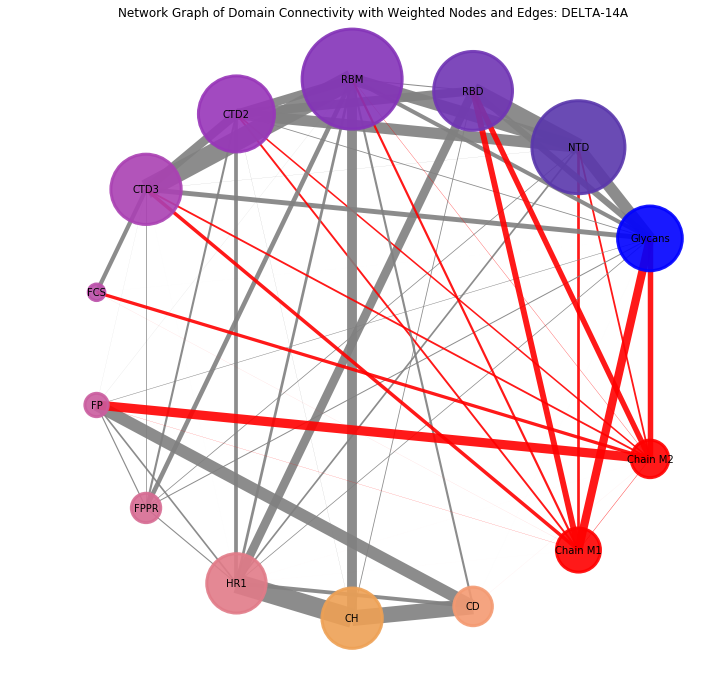

In [9]:
###WT

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# Function to read edges from a file
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = float(parts[4])
            edges.append((res1, res2, weight))
    return edges

# Function to read PDB data
def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                if len(parts) < 6:
                    continue  # Handle lines with unexpected format
                residue_type = parts[3]
                chain = parts[4]
                try:
                    residue_number = int(parts[5])
                except ValueError:
                    continue
                pdb_data[residue_number] = (residue_type, chain)
    return pdb_data

# Function to determine domain of a residue for WT
def get_domain(residue):
    domain_ranges = {
        'NTD': set(range(0, 278)).union(range(1128, 1406)).union(range(2256, 2535)),
        'RBD': set(range(318, 515)).union(range(1446, 1643)).union(range(2574, 2771)),
        'RBM': set(range(424, 495)).union(range(1552, 1623)).union(range(1680, 2751)),
        'CTD2': set(range(516, 576)).union(range(1644, 1705)).union(range(2772, 2833)),
        'CTD3': set(range(577, 662)).union(range(678, 684)).union(range(1705, 1790)).union(range(1806, 1812)).union(range(2833, 2918)).union(range(2934, 2940)),
        'FCS': set(range(662, 677)).union(range(1790, 1805)).union(range(2918, 2933)),
        'FP': set(range(804, 821)).union(range(1932, 1949)).union(range(3060, 3077)),
        'FPPR': set(range(822, 842)).union(range(1950, 1970)).union(range(3078, 3098)),
        'HR1': set(range(897, 972)).union(range(2025, 2100)).union(range(3153, 3228)),
        'CH': set(range(972, 1021)).union(range(2100, 2149)).union(range(3228, 3277)),
        'CD': set(range(1022, 1055)).union(range(2150, 2183)).union(range(3278, 3311)),
        'Glycans': range(3384, 3878),
       # 'Chain M MM1': range(3879, 3998),
       # 'Chain N MM1': range(4418, 4536),
       # 'Chain O MM1': range(4537, 4655),
       # 'Chain P MM2': range(3998, 4137),
       # 'Chain Q MM2': range(4278, 4417),
       # 'Chain R MM2': range(4138, 4277)  
        #'Mucins': range(3379, 4657)
        'Chain M1': set(range(3879, 3998)).union(range(4418, 4536)).union(range(4537, 4655)),
        'Chain M2': set(range(3998, 4137)).union(range(4278, 4417)).union(range(4138, 4277))
    }
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None


# Function to calculate domain connectivity with uniform weights
def calculate_domain_connectivity(edges, pdb_data):
    domain_connections = defaultdict(lambda: defaultdict(float))
    total_weights = defaultdict(float)

    for res1, res2, weight in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        
        if domain1 and domain2 and domain1 != domain2:
            domain_connections[domain1][domain2] += weight
            domain_connections[domain2][domain1] += weight  # Make it symmetric
            total_weights[domain1] += weight
            total_weights[domain2] += weight

    # Normalize the weights to make them uniform
    for domain1 in domain_connections:
        for domain2 in domain_connections[domain1]:
            domain_connections[domain1][domain2] /= (total_weights[domain1] + total_weights[domain2])

    return domain_connections, total_weights

# Function to create a circular layout
def circular_layout(G, order):
    pos = {}
    angle = 2 * math.pi / len(order)
    for i, node in enumerate(order):
        theta = i * angle
        pos[node] = (math.cos(theta), math.sin(theta))
    return pos

# Function to plot the connectivity network
def plot_connectivity_network(domain_connections, total_weights, node_border_width=2.0):
    G = nx.Graph()
    
    # Add nodes with cumulative weights as node attributes
    for domain, weight in total_weights.items():
        G.add_node(domain, weight=weight)
    
    # Add edges with normalized weights
    for domain1, connections in domain_connections.items():
        for domain2, weight in connections.items():
            if domain1 != domain2:
                G.add_edge(domain1, domain2, weight=weight)
    
    # Define the custom order of nodes, including 'Chain M2'
    node_order = [
        'Mucins', 'Glycans', 'NTD', 'RBD', 'RBM', 'CTD2', 'CTD3', 'FCS', 'FP', 'FPPR', 
        'HR1', 'CH', 'CD', 'Chain M1', 'Chain M2'
    ]
    
    # Use the circular layout
    pos = circular_layout(G, node_order)
    
    # Node sizes scaled by cumulative weight (normalize size)
    node_weights = nx.get_node_attributes(G, 'weight')
    max_node_weight = max(node_weights.values())
    node_sizes = [10000 * (node_weights[node] / max_node_weight) for node in G.nodes()]

    # Edge widths scaled by normalized weights
    edge_weights = nx.get_edge_attributes(G, 'weight')
    max_edge_weight = max(edge_weights.values())
    edge_widths = [100 * weight for weight in edge_weights.values()]
    
    # Define colors for each domain
    domain_colors = {
        'NTD': '#5A37AC',
        'RBD': '#7035B4',
        'RBM': '#8433B8',
        'CTD2': '#9836B9',
        'CTD3': '#AA41B3',
        'FCS': '#BB50AA',
        'FP': '#CA5D9F',
        'FPPR': '#D66C93',
        'HR1': '#E17B88',
        'CH': '#EEA155',
        'CD': '#F49A72',
        'Glycans': 'blue',
        'Chain M1': 'red',
        'Chain M2': 'red',
        'Mucins': 'red'
    }

    node_colors = [domain_colors.get(domain, 'black') for domain in G.nodes()]

    # Set edge colors: red if 'Chain M2' is in the edge, otherwise gray
    #edge_colors = ['red' if 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]
    # Set edge colors: red if 'Chain M1' or 'Chain M2' is in the edge, otherwise gray
    edge_colors = ['red' if 'Chain M1' in (u, v) or 'Chain M2' in (u, v) else 'gray' for u, v in G.edges()]


    plt.figure(figsize=(12, 12))
    plt.gca().set_facecolor('none')  # Remove the white background
    nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=10, 
            edge_color=edge_colors, width=edge_widths, alpha=0.9, edgecolors='black', linewidths=node_border_width)  # Add transparency and solid line around nodes with controlled width
    
    plt.title('Network Graph of Domain Connectivity with Weighted Nodes and Edges: DELTA-14A')
    plt.show()


# Example usage:
edges = read_edge_usage("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/edge_usage_all_wt.txt")  # Your edge data
pdb_data = read_pdb("/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined_wt.pdb")  # Your PDB data
domain_connections, total_weights = calculate_domain_connectivity(edges, pdb_data)
plot_connectivity_network(domain_connections, total_weights, node_border_width=3.0)  # Adjust the border width as needed


In [10]:
pwd


'/Users/carlacalvo/Documents/GitHub/MDrepo/spike'